In [14]:
!pip install earthengine-api geemap requests pandas matplotlib seaborn scikit-learn -q


In [15]:
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from datetime import datetime, timedelta
import requests
import warnings
warnings.filterwarnings('ignore')

# Authenticate GEE (run once in terminal: earthengine authenticate)
ee.Authenticate()
ee.Initialize(project='capstone-484914')
print("GEE initialized successfully!")

GEE initialized successfully!


In [16]:
## 2. District Data (Lat/Lon Centers)
districts = [
    {'name': 'Gasabo', 'lat': -1.92, 'lon': 30.115},
    {'name': 'Kicukiro', 'lat': -2.0, 'lon': 30.115},
    {'name': 'Nyarugenge', 'lat': -1.98, 'lon': 30.03},
    {'name': 'Burera', 'lat': -1.35, 'lon': 29.76},
    {'name': 'Gakenke', 'lat': -1.575, 'lon': 29.81},
    {'name': 'Gicumbi', 'lat': -1.62, 'lon': 30.1},
    {'name': 'Musanze', 'lat': -1.5, 'lon': 29.64},
    {'name': 'Rulindo', 'lat': -1.725, 'lon': 29.925},
    {'name': 'Bugesera', 'lat': -2.2, 'lon': 30.1},
    {'name': 'Gatsibo', 'lat': -1.525, 'lon': 30.375},
    {'name': 'Kayonza', 'lat': -2.0, 'lon': 30.6},
    {'name': 'Kirehe', 'lat': -2.375, 'lon': 30.7},
    {'name': 'Ngoma', 'lat': -2.1, 'lon': 30.425},
    {'name': 'Nyagatare', 'lat': -1.25, 'lon': 30.375},
    {'name': 'Rwamagana', 'lat': -1.95, 'lon': 30.375},
    {'name': 'Gisagara', 'lat': -2.675, 'lon': 29.925},
    {'name': 'Huye', 'lat': -2.575, 'lon': 29.725},
    {'name': 'Kamonyi', 'lat': -2.0, 'lon': 29.925},
    {'name': 'Muhanga', 'lat': -2.1, 'lon': 29.675},
    {'name': 'Nyamagabe', 'lat': -2.7, 'lon': 29.6},
    {'name': 'Nyanza', 'lat': -2.425, 'lon': 29.9},
    {'name': 'Nyaruguru', 'lat': -2.8, 'lon': 29.6},
    {'name': 'Ruhango', 'lat': -2.2, 'lon': 29.775},
    {'name': 'Karongi', 'lat': -2.1, 'lon': 29.3},
    {'name': 'Ngororero', 'lat': -1.85, 'lon': 29.6},
    {'name': 'Nyabihu', 'lat': -1.7, 'lon': 29.55},
    {'name': 'Nyamasheke', 'lat': -2.275, 'lon': 29.175},
    {'name': 'Rubavu', 'lat': -1.675, 'lon': 29.3},
    {'name': 'Rusizi', 'lat': -2.625, 'lon': 29.075},
    {'name': 'Rutsiro', 'lat': -1.9, 'lon': 29.35},
]

In [17]:
## 3. Data Fetch Functions
def fetch_ndvi(lat, lon, start_date='2023-01-01', end_date=None):
    if end_date is None:
        end_date = datetime.now().strftime('%Y-%m-%d')

    point = ee.Geometry.Point([lon, lat])
    region = point.buffer(5000)  # 5km buffer

    modis = ee.ImageCollection('MODIS/006/MOD13Q1') \
        .filterBounds(region) \
        .filterDate(start_date, end_date) \
        .select('NDVI')

    image_count = modis.size().getInfo()
    print(f"Found {image_count} MODIS images for {lat},{lon}")

    if image_count == 0:
        return pd.DataFrame(columns=['date', 'mean_ndvi'])

    def get_ndvi(img):
        ndvi_raw = img.reduceRegion(ee.Reducer.mean(), region, 250).get('NDVI')
        ndvi_scaled = ee.Number(ndvi_raw).multiply(0.0001) if ndvi_raw else None
        date_str = img.date().format('YYYY-MM-dd')
        return ee.Feature(None, {'date': date_str, 'mean_ndvi': ndvi_scaled})

    features = modis.map(get_ndvi)
    data = features.toList(features.size()).getInfo()

    ndvi_data = [
        {'date': f['properties']['date'], 'mean_ndvi': f['properties']['mean_ndvi']}
        for f in data if f['properties']['mean_ndvi'] is not None
    ]

    df = pd.DataFrame(ndvi_data)
    if not df.empty:
        df['date'] = pd.to_datetime(df['date'])
    return df

def fetch_weather(lat, lon, start_date='2023-01-01', end_date=None, forecast=False):
    if end_date is None:
        end_date = datetime.now().strftime('%Y-%m-%d')

    if forecast:
        url = f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&daily=temperature_2m_mean,precipitation_sum&timezone=Africa/Kigali"
    else:
        url = f"https://archive-api.open-meteo.com/v1/archive?latitude={lat}&longitude={lon}&start_date={start_date}&end_date={end_date}&daily=temperature_2m_mean,precipitation_sum&timezone=Africa/Kigali"

    response = requests.get(url)
    if response.status_code != 200:
        print(f"Weather API error: {response.status_code}")
        return pd.DataFrame(columns=['date', 'mean_temp_c', 'total_rain_mm'])

    data = response.json()['daily']
    df = pd.DataFrame({
        'date': pd.to_datetime(data['time']),
        'mean_temp_c': data['temperature_2m_mean'],
        'total_rain_mm': data['precipitation_sum']
    })
    return df

In [18]:
## 4. Build Historical Dataset (Loop over all districts)
data = []
for d in districts:
    print(f"Fetching data for {d['name']}...")
    ndvi = fetch_ndvi(d['lat'], d['lon'], '2023-01-01', '2026-02-01')
    weather = fetch_weather(d['lat'], d['lon'], '2023-01-01', '2026-02-01')
    df = pd.merge(ndvi, weather, on='date', how='outer').fillna(method='ffill').fillna(0)
    df['district'] = d['name']
    df['yield_t_ha'] = 1.5 + 2*df['mean_ndvi'] + 0.05*df['total_rain_mm'] - 0.1*df['mean_temp_c'] + np.random.normal(0, 0.3, len(df))
    data.append(df)

full_df = pd.concat(data).reset_index(drop=True)
print("Full dataset shape:", full_df.shape)
print(full_df.head())

Fetching data for Gasabo...
Found 3 MODIS images for -1.92,30.115
Fetching data for Kicukiro...
Found 3 MODIS images for -2.0,30.115
Fetching data for Nyarugenge...
Found 3 MODIS images for -1.98,30.03
Fetching data for Burera...
Found 3 MODIS images for -1.35,29.76
Fetching data for Gakenke...
Found 3 MODIS images for -1.575,29.81
Fetching data for Gicumbi...
Found 3 MODIS images for -1.62,30.1
Fetching data for Musanze...
Found 3 MODIS images for -1.5,29.64
Fetching data for Rulindo...
Found 3 MODIS images for -1.725,29.925
Fetching data for Bugesera...
Found 3 MODIS images for -2.2,30.1
Fetching data for Gatsibo...
Found 3 MODIS images for -1.525,30.375
Fetching data for Kayonza...
Found 3 MODIS images for -2.0,30.6
Fetching data for Kirehe...
Found 3 MODIS images for -2.375,30.7
Fetching data for Ngoma...
Found 3 MODIS images for -2.1,30.425
Fetching data for Nyagatare...
Found 3 MODIS images for -1.25,30.375
Fetching data for Rwamagana...
Found 3 MODIS images for -1.95,30.375
Fetc

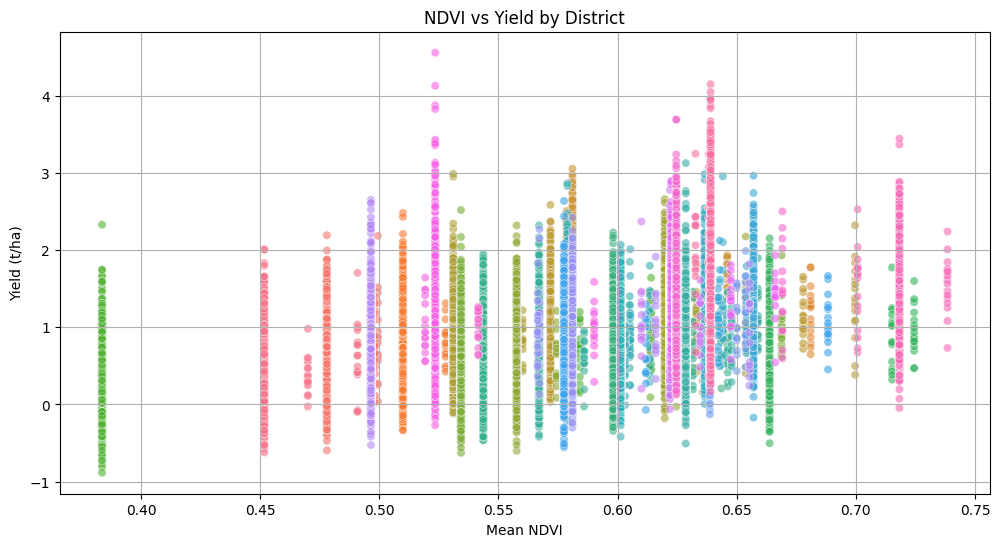

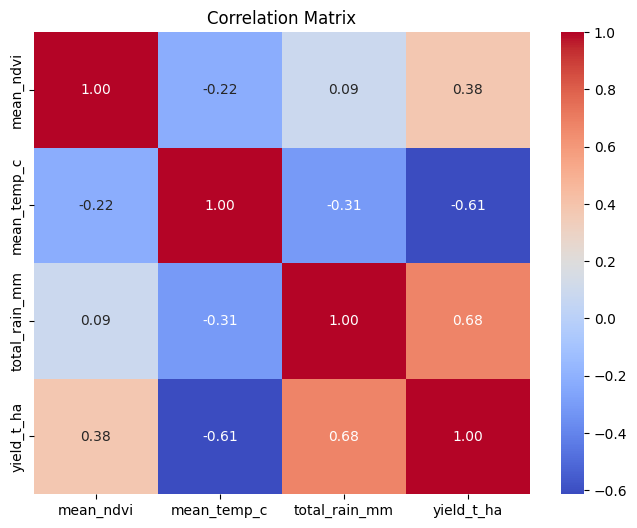

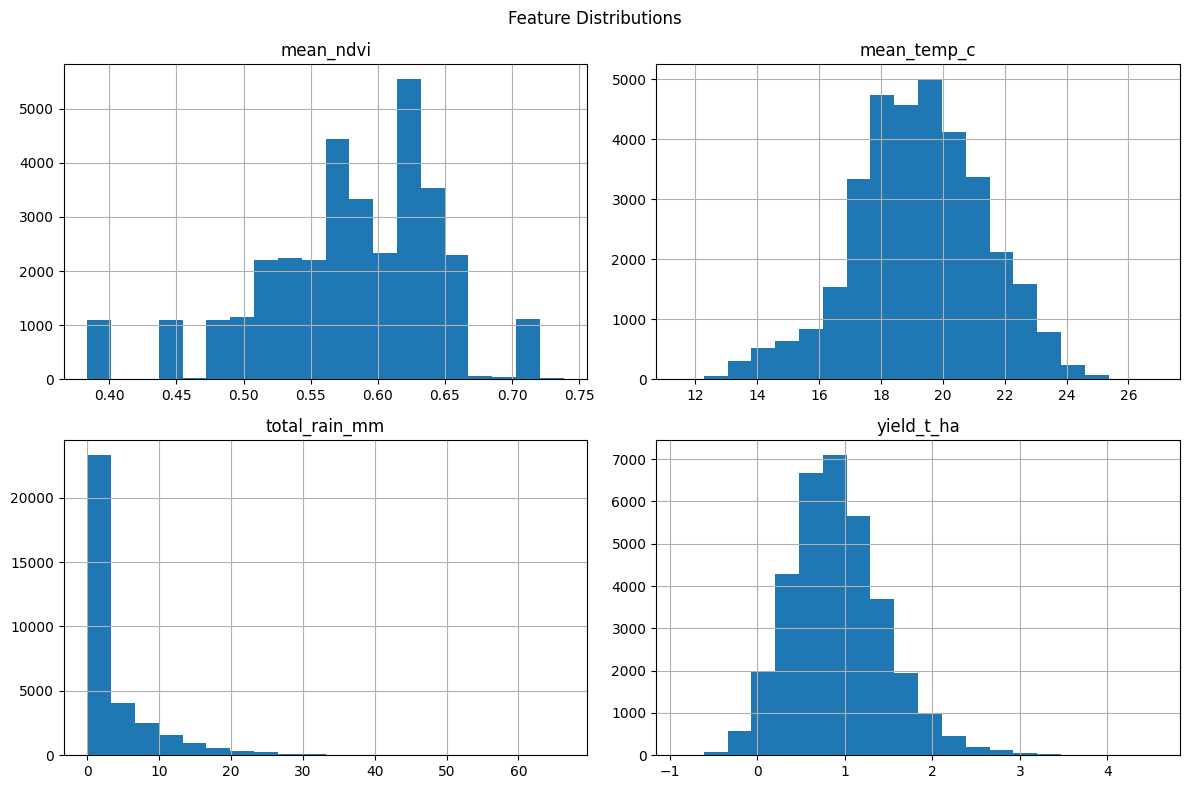

Engineered data head:
        date  mean_ndvi  mean_temp_c  total_rain_mm district  yield_t_ha  \
0 2023-01-01   0.490874         18.6            0.1   Gasabo    0.805350   
1 2023-01-02   0.490874         19.0            0.0   Gasabo    0.388531   
2 2023-01-03   0.490874         19.2            0.2   Gasabo    0.632980   
3 2023-01-04   0.490874         19.6            0.9   Gasabo   -0.073989   
4 2023-01-05   0.490874         19.4            3.0   Gasabo    0.997044   

   cum_rain_30d  ndvi_roll_mean  temp_anomaly  month  
0           0.1        0.490874     -1.921454      1  
1           0.1        0.490874     -1.521454      1  
2           0.3        0.490874     -1.321454      1  
3           1.2        0.490874     -0.921454      1  
4           4.2        0.490874     -1.121454      1  


In [19]:

# Visualization 1: NDVI vs Yield
plt.figure(figsize=(12, 6))
sns.scatterplot(x='mean_ndvi', y='yield_t_ha', hue='district', data=full_df, legend=False, alpha=0.6)
plt.title('NDVI vs Yield by District')
plt.xlabel('Mean NDVI')
plt.ylabel('Yield (t/ha)')
plt.grid(True)
plt.show()

# Visualization 2: Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(full_df[['mean_ndvi', 'mean_temp_c', 'total_rain_mm', 'yield_t_ha']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Visualization 3: Distributions
full_df[['mean_ndvi', 'mean_temp_c', 'total_rain_mm', 'yield_t_ha']].hist(figsize=(12, 8), bins=20)
plt.suptitle('Feature Distributions')
plt.tight_layout()
plt.show()

# Data Engineering
full_df['cum_rain_30d'] = full_df.groupby('district')['total_rain_mm'].rolling(window=30, min_periods=1).sum().reset_index(0, drop=True)
full_df['ndvi_roll_mean'] = full_df.groupby('district')['mean_ndvi'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
full_df['temp_anomaly'] = full_df.groupby('district')['mean_temp_c'].transform(lambda x: x - x.mean())
full_df['month'] = full_df['date'].dt.month

print("Engineered data head:")
print(full_df.head())

In [20]:
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)

RMSE: 0.30 t/ha
R² Score: 0.68
MAPE: 1.269 (comparable to SMART-CYPS range 0.177–0.339)

Feature Importance:
          feature  importance
6   total_rain_mm    0.569455
4     mean_temp_c    0.292332
0       mean_ndvi    0.043494
2  ndvi_roll_mean    0.042829
1    cum_rain_30d    0.022250
3    temp_anomaly    0.021318
5           month    0.008322


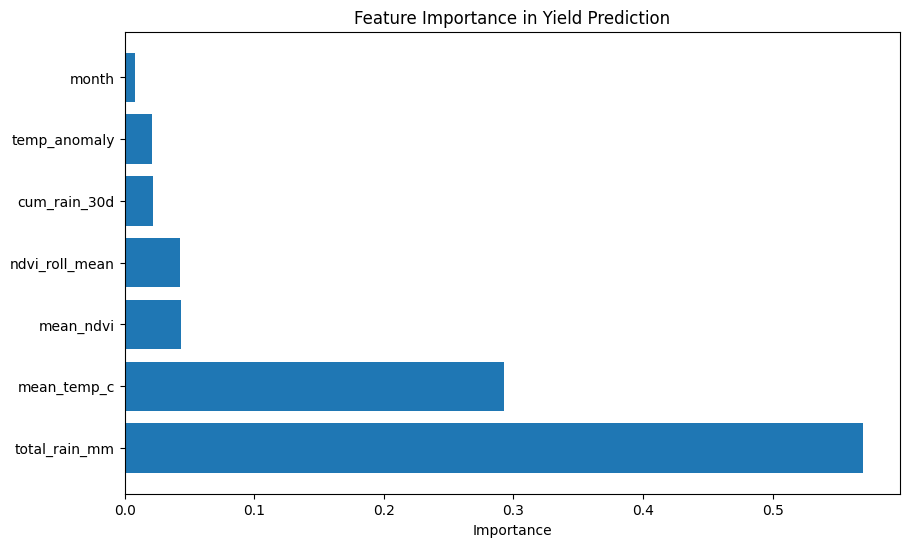

Model successfully saved as 'crop_yield_random_forest_model.pkl'

Quick load test - Predictions from saved model (first 5):
[0.16521026 0.28605836 0.65997775 0.38033129 0.92620631]

Original predictions (first 5):
[0.16521026 0.28605836 0.65997775 0.38033129 0.92620631]
Load test passed: Saved model works correctly!


In [21]:
features = ['mean_ndvi', 'cum_rain_30d', 'ndvi_roll_mean', 'temp_anomaly', 'mean_temp_c', 'month', 'total_rain_mm']
X = full_df[features]
y = full_df['yield_t_ha']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model.fit(X_train, y_train)

preds = model.predict(X_test)

# Fix: Removed 'squared=False' and applied np.sqrt to get RMSE
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)
mape = mean_absolute_percentage_error(y_test, preds)

print(f"RMSE: {rmse:.2f} t/ha")
print(f"R² Score: {r2:.2f}")
print(f"MAPE: {mape:.3f}")

# Feature importance
importances = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
importances = importances.sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(importances)

plt.figure(figsize=(10, 6))
plt.barh(importances['feature'], importances['importance'])
plt.title('Feature Importance in Yield Prediction')
plt.xlabel('Importance')
plt.show()

#################
# After model.fit(X_train, y_train) and metrics calculation

# Save the trained model (using pickle - simple and reliable)
import pickle

model_filename = 'crop_yield_random_forest_model.pkl'

with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

print(f"Model successfully saved as '{model_filename}'")

# Optional: Quick load test to confirm it works
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

# Test prediction with first 5 test samples
test_preds_loaded = loaded_model.predict(X_test.iloc[0:5])
print("\nQuick load test - Predictions from saved model (first 5):")
print(test_preds_loaded)

print("\nOriginal predictions (first 5):")
print(preds[0:5])

# If they match → save is successful
if np.allclose(test_preds_loaded, preds[0:5]):
    print("Load test passed: Saved model works correctly!")
else:
    print("Warning: Load test mismatch - check scikit-learn version consistency.")

In [24]:
def predict_future(model, district_name, future_date_str):
    """Predict yield for a future date using forecast weather and historical NDVI mean."""
    future_date = datetime.strptime(future_date_str, '%Y-%m-%d')
    future_start = (future_date - timedelta(days=90)).strftime('%Y-%m-%d')

    d = next(d for d in districts if d['name'] == district_name)

    future_weather = fetch_weather(d['lat'], d['lon'], future_start, future_date_str, forecast=True)

    if future_weather.empty:
        print("No forecast data — using historical average")
        historical_weather = fetch_weather(d['lat'], d['lon'], '2025-01-01', '2025-12-31')
        future_weather = historical_weather.tail(30)

    future_weather['cum_rain_30d'] = future_weather['total_rain_mm'].rolling(window=30, min_periods=1).sum()
    future_weather['mean_temp_c'] = future_weather['mean_temp_c'].fillna(future_weather['mean_temp_c'].mean())
    future_weather['temp_anomaly'] = future_weather['mean_temp_c'] - future_weather['mean_temp_c'].mean()
    future_weather['month'] = future_weather['date'].dt.month

    historical_ndvi = full_df[full_df['district'] == district_name]['mean_ndvi'].mean()
    future_weather['mean_ndvi'] = historical_ndvi
    future_weather['ndvi_roll_mean'] = historical_ndvi

    future_X = future_weather[features].mean().to_frame().T
    pred = model.predict(future_X)
    return pred[0]

# Example
future_yield = predict_future(model, 'Gasabo', '2026-03-01')
print(f"Predicted yield for Gasabo on 2026-03-01: {future_yield:.2f} t/ha")

Predicted yield for Gasabo on 2026-03-01: 0.41 t/ha


In [25]:
## 8. Future Prediction (with Open-Meteo Forecast)
def predict_future(model, district_name, future_date_str):
    """Predict yield for a future date using forecast weather and historical NDVI mean."""
    future_date = datetime.strptime(future_date_str, '%Y-%m-%d')
    future_start = (future_date - timedelta(days=90)).strftime('%Y-%m-%d')

    d = next(d for d in districts if d['name'] == district_name)

    # Forecast weather (Open-Meteo supports up to 16 days ahead)
    future_weather = fetch_weather(d['lat'], d['lon'], future_start, future_date_str, forecast=True)

    if future_weather.empty:
        print("No forecast data — using historical average")
        historical_weather = fetch_weather(d['lat'], d['lon'], '2025-01-01', '2025-12-31')
        future_weather = historical_weather.tail(30)

    future_weather['cum_rain_30d'] = future_weather['total_rain_mm'].rolling(window=30, min_periods=1).sum()
    future_weather['mean_temp_c'] = future_weather['mean_temp_c'].fillna(future_weather['mean_temp_c'].mean())
    future_weather['temp_anomaly'] = future_weather['mean_temp_c'] - future_weather['mean_temp_c'].mean()
    future_weather['month'] = future_weather['date'].dt.month

    historical_ndvi = full_df[full_df['district'] == district_name]['mean_ndvi'].mean()
    future_weather['mean_ndvi'] = historical_ndvi
    future_weather['ndvi_roll_mean'] = historical_ndvi  # Proxy for future

    future_X = future_weather[features].mean().to_frame().T
    pred = model.predict(future_X)
    return pred[0]

# Example future prediction
future_yield = predict_future(model, 'Gasabo', '2026-03-01')
print(f"Predicted yield for Gasabo on 2026-03-01: {future_yield:.2f} t/ha")

Predicted yield for Gasabo on 2026-03-01: 0.41 t/ha
